In [1]:
import os
import math

In [2]:
import ROOT as R
import numpy as np

Welcome to JupyROOT 6.22/00


In [3]:
R.gStyle.SetOptStat(0)
R.gStyle.SetGridColor(16)
R.gStyle.SetPadRightMargin(0.05)
R.gStyle.SetPadLeftMargin(0.15)

In [30]:
def draw(histos, config, out_file=None):
    size = (800, 800)
    if 'canvas' in config:
        size = config['canvas']
    C = R.TCanvas("canvas", "", size[0], size[1])
    C.SetGridx()
    C.SetGridy()
    R.SetOwnership(C, False)
    n = len(histos)
    leg = None
    if 'leg' in config:
        leg = R.TLegend(0.5,0.95 - 1*len(config['leg'])*0.06, 0.95,0.9)
        leg.SetMargin(0.2)
        leg.SetTextSize(0.03)
        leg.SetNColumns(1)
        R.SetOwnership(leg, 0)
    h_axis = None
    h_toDraw = []
    for iH, h_ori in enumerate(histos):
        h = h_ori.Clone()
        if iH == 0:
            h_axis = h
        if 'rebin' in config:
            h.Rebin(config['rebin'])
#         h.Rebin(2)
        if 'norm' in config:
            h.Scale(config['norm'] / h.Integral())
        R.SetOwnership(h, 0)
        h.SetLineWidth(2)
        if 'style' in config:
            h.SetLineStyle(config['style'][iH])
        h.SetLineColor(config['color'][iH])
#         h.SetLineColor(1)
#         h.SetFillColor(config['color'][iH])
        if leg and len(config['leg']) > iH:
#             leg.AddEntry(h, config['leg'][iH], 'l')
            leg.AddEntry(h, config['leg'][iH], 'l').SetTextColor(config['color'][iH])
        h_toDraw.append(h)
    # Actually drawing
    h_axis.Draw('AXIS')
    h_axis.Draw('AXIG same')
    for iH, h in enumerate(h_toDraw):
        drawopt = 'hist'
        if 'drawopt' in config:
            drawopt = config['drawopt']
        drawopt += "same"
        h.Draw(drawopt)
    h_axis.Draw('AXIG same')
    if leg:
        leg.Draw()
        h_axis.GetYaxis().SetMaxDigits(4)
    if 'y' in config:
        h_axis.GetYaxis().SetRangeUser(*config['y'])
    if 'x' in config:
        h_axis.GetXaxis().SetRangeUser(*config['x'])
    if 'logY' in config:
        C.SetLogy(config['logY'])
    if 'logX' in config:
        C.SetLogx(config['logX'])
    C.RedrawAxis()
    C.Draw()
    if out_file:
        C.Print(out_file)

### Drawing time distributions for each VTX layer

In [68]:
DIR_IN = '/Users/nbartosi/cernbox/work/mu_collider/data/2021_11_19_dlfilter/'
# range_names = ['3sigma', '1ns', '10ns', '10us']
range_names = ['1ns_nodt', '1ns']
configs = {
    '3sigma': (0.1, 1),
    '1ns': (1, 5),
    '10ns': (10, 50),
    '10us': (10, 50),
    '10us_nodt': (10, 50),
}
try:
    for file_in in files_in:
        file_in.Close()
except:
    pass
files_in = {name: R.TFile(os.path.join(DIR_IN, 'digi/bib_trk_{0:s}_tuple.root'.format(name))) for name in range_names}
trees = {name: [f.Get(t) for t in ['LCTuple', 'LCTuple_DL']] for name, f in files_in.items()}


2 0 429436
2 1 515481
2 2 325071
2 3 186990
2 0 417306
2 1 446134
2 2 144881
2 3 31475


Warning in <TFile::Append>: Replacing existing TH1: h0 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h0 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h3 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h3 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h3 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h0 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h2 (Potential memory leak).
Warning in <TFile::Append>: Replacing ex

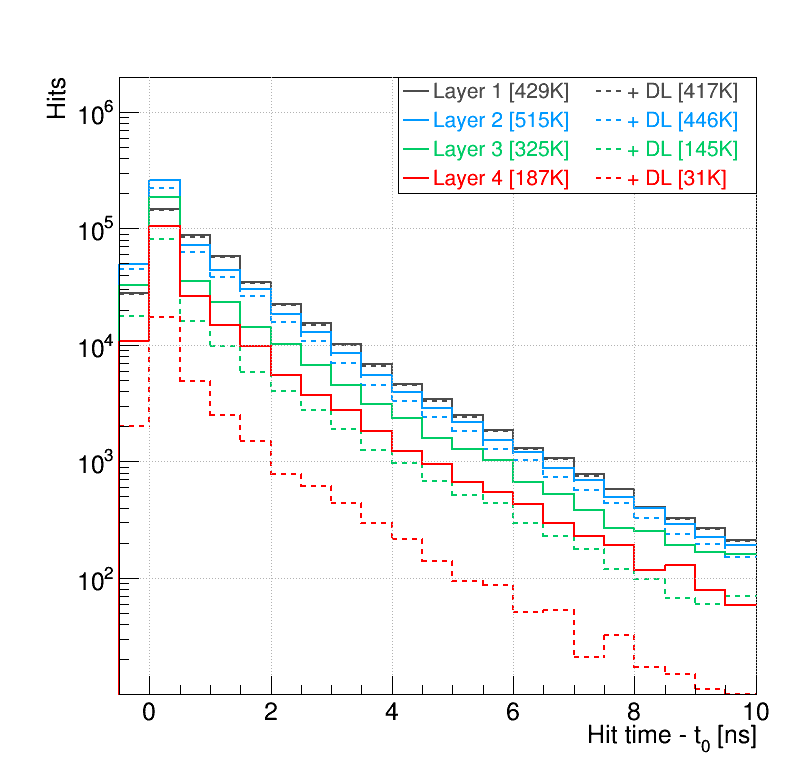

In [15]:
DIR_OUT = os.path.join(DIR_IN, 'plots')
nLayers = 4
ori = 2
for name, rtrees in trees.items():
    histos = {}
    for cut, tree in zip(('all', 'dl'), rtrees):
        layers = range(nLayers)
        histos[cut] = [R.TH1F('h{0:d}'.format(i), ';Hit time - t_{0} [ns];Hits', 1100, -1, 10) for i in layers]
        for layer in layers:
            h = histos[cut][layer]
            if layer <= 3:
                nev = tree.Draw('thtim >> h{0:d}'.format(layer), 'abs(thpoz) > 70.0 && int((int(thci0/128)%64)/2) == {1:d}'.format(ori, layer), 'goff')
            else:
                nev = tree.Draw('thtim >> h{0:d}'.format(layer), 'abs(thpoz) > 70.0 && (int(thci0/128)%64) >= {1:d}'.format(ori, layer), 'goff')
            print(ori, layer, nev)
    legs = []
    for l in layers:
        legs.append('Layer {0:d} [{1:.0f}K]'.format(l+1, histos['all'][l].GetEntries()/1e3))
        legs.append('+ DL [{0:.0f}K]'.format(histos['dl'][l].GetEntries()/1e3))
    draw([histos[c][l] for l in layers for c in ['all', 'dl'] ], 
         {'color': [12]*2 + [R.kAzure+7]*2 + [R.kTeal+2]*2 + [2]*2,
          'style': [1, 7]*4,
          'leg': legs,
          'rebin': configs[name][1],
#           'rebin': 50,
          'logY': True,
          'x': (-0.1, configs[name][0]),
          'y': (10, 2e6),
#          }, None)
         }, os.path.join(DIR_OUT, 'hit_time_ori_{0:d}_{1:s}.pdf'.format(ori, name)))


### Drawing hit multiplicities per layer for different hit selections

1 3 1131192
1 3 1065166
1 3 1131192
1 3 989778


Warning in <TFile::Append>: Replacing existing TH1: h_1ns_nodt_all (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_1ns_nodt_dl (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_1ns_dl (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file /Users/nbartosi/cernbox/work/mu_collider/data/2021_11_19_dlfilter/plots/hit_layer_ori_1_1ns_nodt.pdf has been created


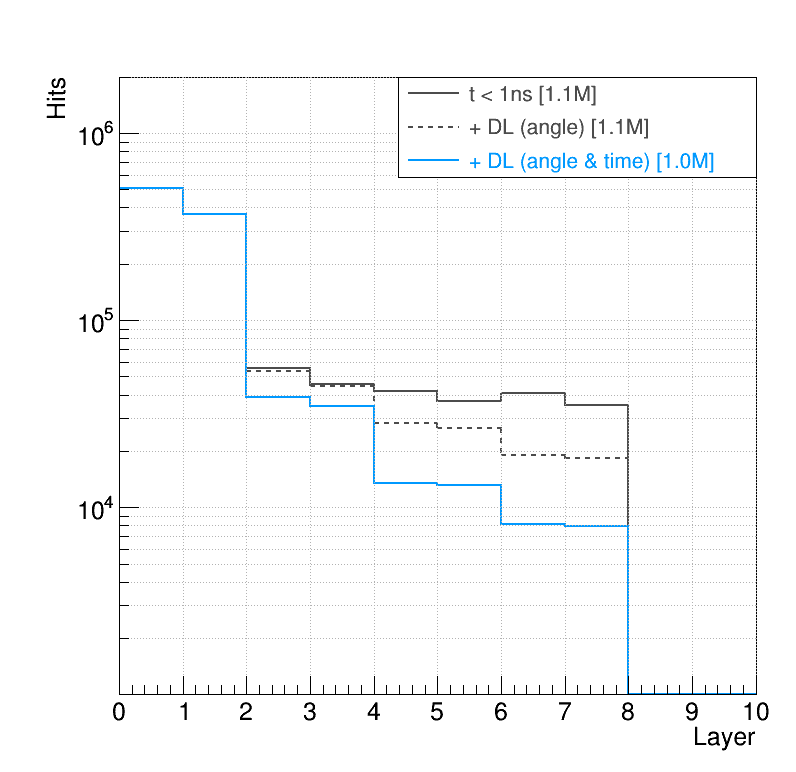

In [37]:
DIR_OUT = os.path.join(DIR_IN, 'plots')
nLayers = 4
ori = 1
histos = {}
legs = []
for name, rtrees in trees.items():
    for cut, tree in zip(('all', 'dl'), rtrees):
        layers = range(nLayers)
        hname = f'h_{name}_{cut}'
        h = R.TH1F(hname, ';Layer;Hits', 10, 0, 10)
        nev = tree.Draw(f'int(thci0/128)%64 >> {hname}', 'abs(thpoz) < 70.0', 'goff')
        print(ori, layer, nev)
        histos[(name, cut)] = h
    legs.append('[{0:.1f}M]'.format(histos[(name, 'all')].GetEntries()/1e6))
    legs.append('[{0:.1f}M]'.format(histos[(name, 'dl')].GetEntries()/1e6))
draw([histos[comb] for comb in [('1ns_nodt', 'all'), ('1ns_nodt', 'dl'), ('1ns', 'dl')] ], {
    'color': [12]*2 + [R.kAzure+7]*2 + [R.kTeal+2]*2 + [2]*2,
    'style': [1, 7]*4,
    'leg': ['t < 1ns '+legs[0], '+ DL (angle) '+legs[1], '+ DL (angle & time) '+legs[3]],
    'rebin': 1,
    'logY': True,
#     'x': (-0.1, configs[name][0]),
    'y': (1e3, 2e6),
#          }, None)
}, os.path.join(DIR_OUT, 'hit_layer_ori_{0:d}_1ns_nodt.pdf'.format(ori)))


### Calculating detector-layer areas for hit-density calculations

In [40]:
sens_area = {}  # in mm
for sub in range(2):
    sens_area.update({('b', l*2+sub): 130*a for l, a in enumerate([16*13, 15*23, 21*24, 29*24])})
er_max = 115-3
for sub in range(2):
    sens_area.update({('e', l*2+sub): math.tan(math.pi/16)*(r+1+er_max+1)*(er_max-r) for l, r in enumerate([22+3, 28+3, 35+3, 50+3])})
    

### Drawing hit densities per layers

2 7 1131192
2 7 1065166
2 7 1131192
2 7 989778


Warning in <TFile::Append>: Replacing existing TH1: h_1ns_nodt_all (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_1ns_nodt_dl (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_1ns_dl (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file /Users/nbartosi/cernbox/work/mu_collider/data/2021_11_19_dlfilter/plots/hit_density_layer_ori_2_1ns_nodt.pdf has been created


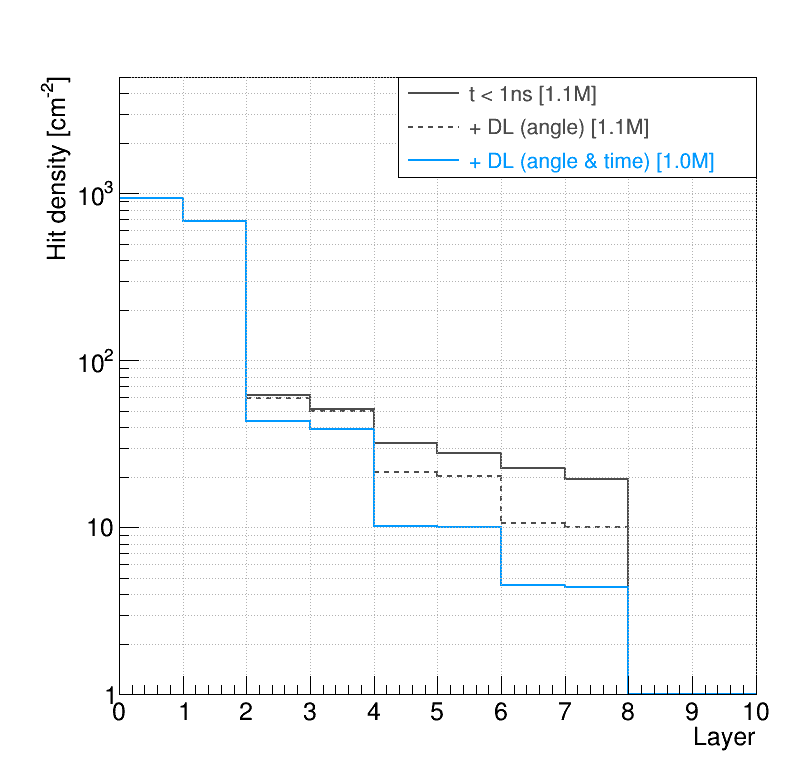

In [70]:
DIR_OUT = os.path.join(DIR_IN, 'plots')
nLayers = 4
ori = 2
histos = {}
legs = []
for name, rtrees in trees.items():
    for cut, tree in zip(('all', 'dl'), rtrees):
        layers = range(nLayers)
        hname = f'h_{name}_{cut}'
        h = R.TH1F(hname, ';Layer;Hit density [cm^{-2}]', 10, 0, 10)
        nev = tree.Draw(f'int(thci0/128)%64 >> {hname}', 'abs(thpoz) < 70.0', 'goff')
        print(ori, layer, nev)
        # Correcting for the layer area [cm^2]
        for layer in range(8):
            h.SetBinContent(layer+1, h.GetBinContent(layer+1)/(sens_area[('b', layer)] * 2e-2))
        histos[(name, cut)] = h
    legs.append('[{0:.1f}M]'.format(histos[(name, 'all')].GetEntries()/1e6))
    legs.append('[{0:.1f}M]'.format(histos[(name, 'dl')].GetEntries()/1e6))
draw([histos[comb] for comb in [('1ns_nodt', 'all'), ('1ns_nodt', 'dl'), ('1ns', 'dl')] ], {
    'color': [12]*2 + [R.kAzure+7]*2 + [R.kTeal+2]*2 + [2]*2,
    'style': [1, 7]*4,
    'leg': ['t < 1ns '+legs[0], '+ DL (angle) '+legs[1], '+ DL (angle & time) '+legs[3]],
    'rebin': 1,
    'logY': True,
#     'x': (-0.1, configs[name][0]),
    'y': (1e0, 5e3),
#          }, None)
}, os.path.join(DIR_OUT, 'hit_density_layer_ori_{0:d}_1ns_nodt.pdf'.format(ori)))


In [33]:
def fibb(n):
    m1 = 1
    m2 = 0
    for index in range(n):
        this = m1 + m2
        m2 = m1
        m1 = this
        print(index, this)

In [34]:
fibb(4)

0 1
1 2
2 3
3 5
